# Hourly Energy Consumption Forcasting

# Import Modules

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb


# Data Exploration

In [2]:
df=pd.read_csv('PJMW_hourly.csv')
df.head()

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0


In [4]:
df.index.dtype

dtype('int64')

In [6]:
df=df.set_index('Datetime')
df.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


In [7]:
df.index

Index(['2002-12-31 01:00:00', '2002-12-31 02:00:00', '2002-12-31 03:00:00',
       '2002-12-31 04:00:00', '2002-12-31 05:00:00', '2002-12-31 06:00:00',
       '2002-12-31 07:00:00', '2002-12-31 08:00:00', '2002-12-31 09:00:00',
       '2002-12-31 10:00:00',
       ...
       '2018-01-01 15:00:00', '2018-01-01 16:00:00', '2018-01-01 17:00:00',
       '2018-01-01 18:00:00', '2018-01-01 19:00:00', '2018-01-01 20:00:00',
       '2018-01-01 21:00:00', '2018-01-01 22:00:00', '2018-01-01 23:00:00',
       '2018-01-02 00:00:00'],
      dtype='object', name='Datetime', length=143206)

In [11]:
#transforming index to datetime type
df.index=pd.to_datetime(df.index)
df.index

DatetimeIndex(['2002-12-31 01:00:00', '2002-12-31 02:00:00',
               '2002-12-31 03:00:00', '2002-12-31 04:00:00',
               '2002-12-31 05:00:00', '2002-12-31 06:00:00',
               '2002-12-31 07:00:00', '2002-12-31 08:00:00',
               '2002-12-31 09:00:00', '2002-12-31 10:00:00',
               ...
               '2018-01-01 15:00:00', '2018-01-01 16:00:00',
               '2018-01-01 17:00:00', '2018-01-01 18:00:00',
               '2018-01-01 19:00:00', '2018-01-01 20:00:00',
               '2018-01-01 21:00:00', '2018-01-01 22:00:00',
               '2018-01-01 23:00:00', '2018-01-02 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=143206, freq=None)

<AxesSubplot:title={'center':'visualising energy consumption'}, xlabel='Datetime'>

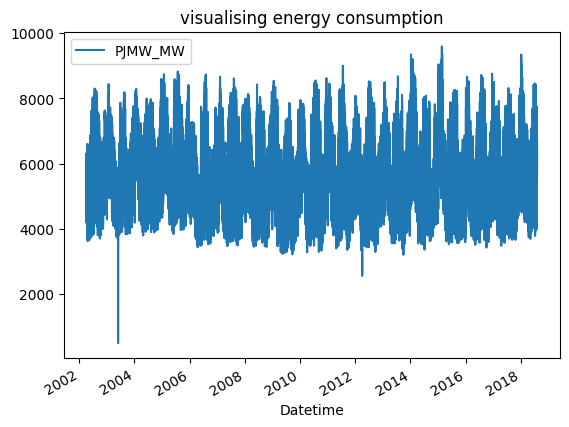

In [13]:
df.plot(title="visualising energy consumption")

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:52: UserWarning: Parsing '20-08-2003' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.le)


<AxesSubplot:title={'center':"energy consumption between '01-08-2003' and '20-08-2003' "}, xlabel='Datetime'>

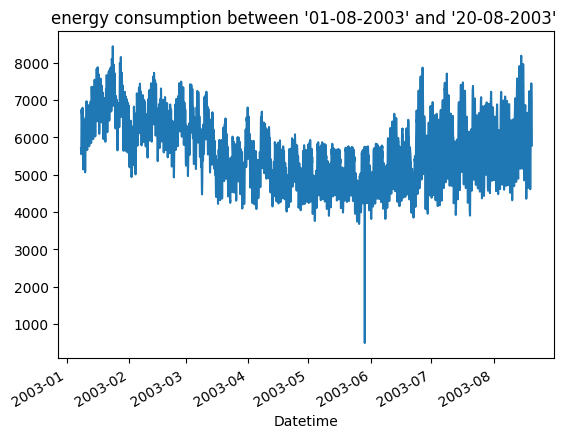

In [23]:
df['PJMW_MW'][(df.index>'01-08-2003')&(df.index<="20-08-2003")].plot(title="energy consumption between '01-08-2003' and '20-08-2003' ")

In [15]:
df['lag']=df['PJMW_MW'].shift(1)
df.head()

,PJMW_MW,lag
Datetime,,
2002-12-31 01:00:00,5077.0,NaN
2002-12-31 02:00:00,4939.0,5077.0
2002-12-31 03:00:00,4885.0,4939.0
2002-12-31 04:00:00,4857.0,4885.0
2002-12-31 05:00:00,4930.0,4857.0


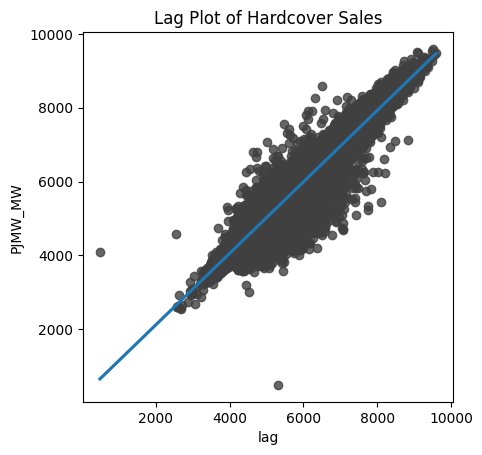

In [21]:
fig, ax = plt.subplots()
ax = sns.regplot(x='lag', y='PJMW_MW', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

lag et PJMW_MW sont bien corrélé du coup lag peut servir comme feature par la suite 

# Create Features

In [26]:
def create_features(df):
    df['hour']=df.index.hour
    df['year']=df.index.year
    df['dayofyear']=df.index.dayofyear
    df['month']=df.index.month
    df['dayofweek']=df.index.dayofweek
    df['weekofyear'] = df.index.isocalendar().week
    df['lag_1']=df['PJMW_MW'].shift(2)
    return df



In [27]:
df=create_features(df)

In [28]:
df.head()

,PJMW_MW,lag,hour,year,dayofyear,month,dayofweek,weekofyear,lag_1
Datetime,,,,,,,,,
2002-12-31 01:00:00,5077.0,NaN,1,2002,365,12,1,1,NaN
2002-12-31 02:00:00,4939.0,5077.0,2,2002,365,12,1,1,NaN
2002-12-31 03:00:00,4885.0,4939.0,3,2002,365,12,1,1,5077.0
2002-12-31 04:00:00,4857.0,4885.0,4,2002,365,12,1,1,4939.0
2002-12-31 05:00:00,4930.0,4857.0,5,2002,365,12,1,1,4885.0


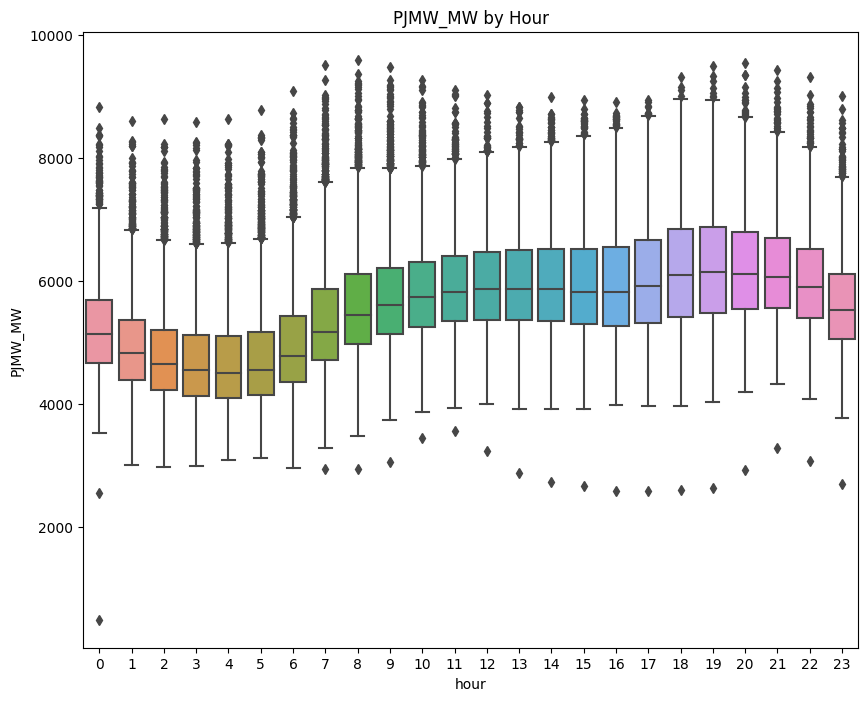

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJMW_MW')
ax.set_title('PJMW_MW by Hour')
plt.show()

in the first hours of the day energy consumption is low

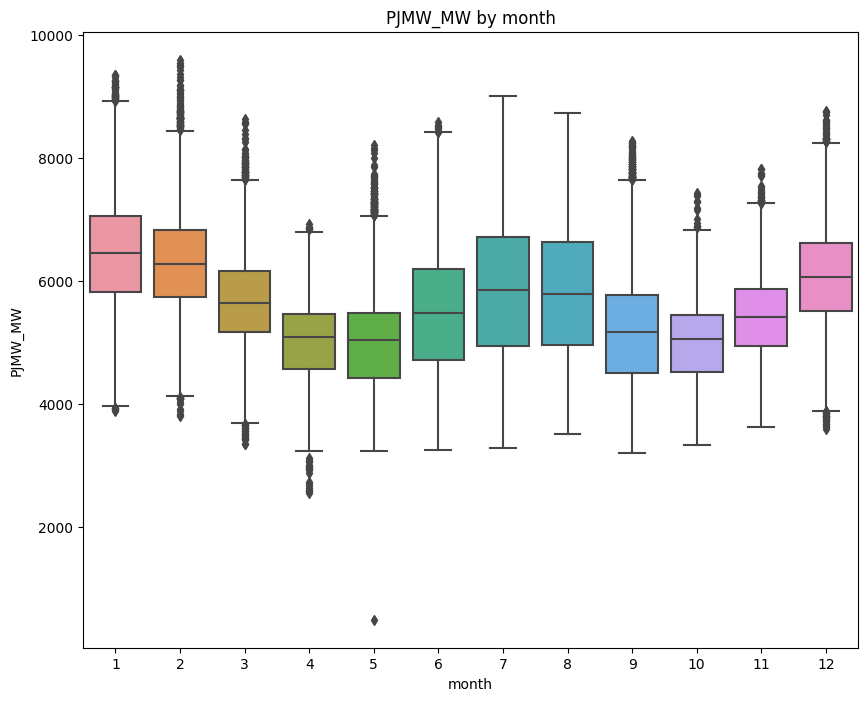

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJMW_MW')
ax.set_title('PJMW_MW by month')
plt.show()

# Split Test and Train Data

In [46]:
df.columns
df=df.dropna()
df.head()

,PJMW_MW,lag,hour,year,dayofyear,month,dayofweek,weekofyear,lag_1
Datetime,,,,,,,,,
2002-12-31 03:00:00,4885.0,4939.0,3,2002,365,12,1,1,5077.0
2002-12-31 04:00:00,4857.0,4885.0,4,2002,365,12,1,1,4939.0
2002-12-31 05:00:00,4930.0,4857.0,5,2002,365,12,1,1,4885.0
2002-12-31 06:00:00,5126.0,4930.0,6,2002,365,12,1,1,4857.0
2002-12-31 07:00:00,5493.0,5126.0,7,2002,365,12,1,1,4930.0


In [81]:
from sklearn.model_selection import train_test_split
y=df['PJMW_MW']
features=['lag', 'hour', 'year', 'dayofyear', 'month', 'lag_1']
X=df[features]
X_train,X_test,y_train,y_test=train_test_split(X,y)


In [51]:
df.dtypes

PJMW_MW       float64
lag           float64
hour            int64
year            int64
dayofyear       int64
month           int64
dayofweek       int64
weekofyear     UInt32
lag_1         float64
dtype: object

In [53]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[20:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5628.83128	validation_1-rmse:5633.87492
[100]	validation_0-rmse:2074.41005	validation_1-rmse:2075.46672
[200]	validation_0-rmse:785.51667	validation_1-rmse:785.55645
[300]	validation_0-rmse:337.98599	validation_1-rmse:338.75770
[400]	validation_0-rmse:204.90585	validation_1-rmse:206.83320
[500]	validation_0-rmse:173.86926	validation_1-rmse:176.74593
[600]	validation_0-rmse:164.75046	validation_1-rmse:168.08417
[700]	validation_0-rmse:160.44133	validation_1-rmse:163.97829
[800]	validation_0-rmse:156.46949	validation_1-rmse:160.12595
[900]	validation_0-rmse:152.90036	validation_1-rmse:156.67144
[999]	validation_0-rmse:149.41922	validation_1-rmse:153.30953


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

<BarContainer object of 6 artists>

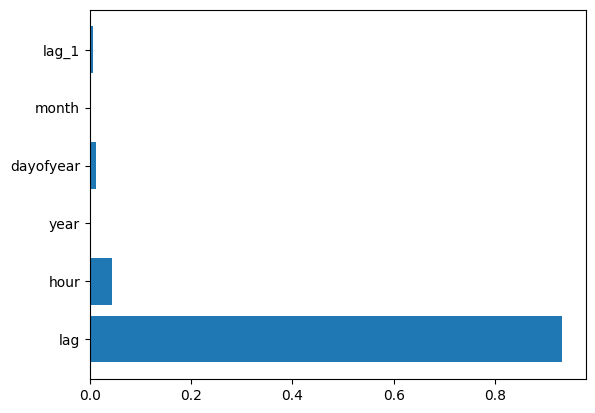

In [59]:
feature_importance=reg.feature_importances_
feature_names=reg.feature_names_in_
plt.barh(feature_names, feature_importance)


In [83]:
from sklearn.metrics import mean_squared_error
y_pred=reg.predict(X_test)
score = np.sqrt(mean_squared_error(y_test,y_pred ))
print(f'RMSE Score on Test set: {score:0.2f}')


RMSE Score on Test set: 146.51


In [85]:
print('the mean value of y_test is:', y_test.mean())
print('the median value of y_test is:', y_test.median())

the mean value of y_test is: 5597.274098488869
the median value of y_test is: 5529.0


In [86]:
print('the pourcentage of the error with reference to the mean value',(score/ y_test.mean())*100,"%")

the pourcentage of the error with reference to the mean value 2.617556704475579 %


the mean_squared error is accepeted in comparaison with the mean value is acceptable